In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tabulate
parent_dir = os.path.join(os.getcwd(), '..', '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility.data import get_loader, EmbeddingDataset
from model.gan import Generator, Discriminator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
from datasets import load_from_disk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128          
condition_dim = 10        
gan_epochs = 20            
generation_size = 1000    
batch_size = 32                

full_dataset = load_from_disk('../../data/full_dataset_new', keep_in_memory=True)
split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

test_x = np.array(test_dataset['embedding'])
test_y = np.array(test_dataset['labels'])

train_x_full = np.array(train_dataset['embedding'])
train_y_full = np.array(train_dataset['labels'])

In [ ]:


train_ds = EmbeddingDataset(train_dataset)
test_ds = EmbeddingDataset(test_dataset)
test_loader = get_loader(test_ds, batch_size=batch_size, shuffle=False)  

[GAN Epoch 12/20] D loss: 0.3991, G loss: 2.4878
[GAN Epoch 13/20] D loss: 0.4260, G loss: 2.1221
[GAN Epoch 14/20] D loss: 0.4214, G loss: 2.1278
[GAN Epoch 15/20] D loss: 0.4195, G loss: 2.0980
[GAN Epoch 16/20] D loss: 0.4063, G loss: 2.0382
[GAN Epoch 17/20] D loss: 0.4418, G loss: 2.1881
[GAN Epoch 18/20] D loss: 0.4298, G loss: 2.1064
[GAN Epoch 19/20] D loss: 0.3945, G loss: 2.1161
[GAN Epoch 20/20] D loss: 0.4463, G loss: 2.0316
KNN Accuracy (After Concatenation) for size 1000: 0.9024

[Real Data Only] Training size: 7872
KNN Accuracy (Real Data) for size 7872: 0.8857
Training Conditional GAN on the same subset...


c:\Users\ss348\Desktop\New folder\GAN_Transformer\SICK\experiment\GAN_different_generation_sizes\..\..\utility\data.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
C:\Users\ss348\AppData\Local\Temp\ipykernel_47920\1390546981.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 1/20] D loss: 0.3051, G loss: 2.5097
[GAN Epoch 2/20] D loss: 0.4309, G loss: 1.8953
[GAN Epoch 3/20] D loss: 0.4370, G loss: 1.8623
[GAN Epoch 4/20] D loss: 0.4889, G loss: 1.5542
[GAN Epoch 5/20] D loss: 0.4532, G loss: 1.5872
[GAN Epoch 6/20] D loss: 0.5155, G loss: 1.3923
[GAN Epoch 7/20] D loss: 0.5232, G loss: 1.2980
[GAN Epoch 8/20] D loss: 0.5362, G loss: 1.2344
[GAN Epoch 9/20] D loss: 0.5703, G loss: 1.1337
[GAN Epoch 10/20] D loss: 0.5650, G loss: 1.1282
[GAN Epoch 11/20] D loss: 0.5715, G loss: 1.0943
[GAN Epoch 12/20] D loss: 0.5849, G loss: 1.0775
[GAN Epoch 13/20] D loss: 0.5757, G loss: 1.0780
[GAN Epoch 14/20] D loss: 0.5790, G loss: 1.0703
[GAN Epoch 15/20] D loss: 0.5682, G loss: 1.0631
[GAN Epoch 16/20] D loss: 0.5577, G loss: 1.1279
[GAN Epoch 17/20] D loss: 0.5709, G loss: 1.1111
[GAN Epoch 18/20] D loss: 0.5657, G loss: 1.1068
[GAN Epoch 19/20] D loss: 0.5686, G loss: 1.1189
[GAN Epoch 20/20] D loss: 0.5774, G loss: 1.0602
KNN Accuracy (After Concatena

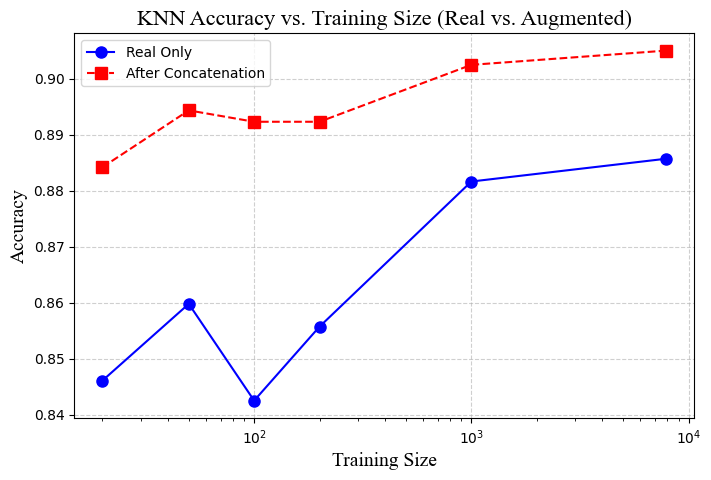

In [4]:

sample_sizes = [20, 50, 100, 200, 1000, len(train_ds)]
knn_accuracy_before = {}
knn_accuracy_after = {}

for size in sample_sizes:
    print(f"\n[Real Data Only] Training size: {size}")
    X_train = train_x_full[:size]
    y_train = train_y_full[:size]

    knn_real = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
    knn_real.fit(X_train, y_train)
    pred_before = knn_real.predict(test_x)
    acc_before = accuracy_score(test_y, pred_before)
    print(f"KNN Accuracy (Real Data) for size {size}: {acc_before:.4f}")
    knn_accuracy_before[size] = acc_before

    print("Training Conditional GAN on the same subset...")
    train_subset = Subset(train_ds, range(size))
    gan_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)

    input_dim = X_train.shape[1]  
    unique_labels = np.unique(train_y_full)
    num_classes_gan = len(unique_labels)

    generator = Generator(
        latent_dim=latent_dim,
        condition_dim=condition_dim,
        num_classes=num_classes_gan,
        start_dim=latent_dim * 2,
        n_layer=3,
        output_dim=input_dim
    ).to(device)
    discriminator = Discriminator(
        condition_dim=condition_dim,
        num_classes=num_classes_gan,
        start_dim=256,
        n_layer=3,
        input_dim=input_dim
    ).to(device)

    adversarial_loss = nn.BCELoss().to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(gan_epochs):
        d_loss_epoch, g_loss_epoch = 0.0, 0.0
        for embeddings, labels in gan_loader:
            embeddings = embeddings.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            b_size = embeddings.size(0)

            valid = torch.ones(b_size, 1, device=device)
            fake = torch.zeros(b_size, 1, device=device)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(b_size, latent_dim, device=device)
            gen_data = generator(z, labels)
            g_loss = adversarial_loss(discriminator(gen_data, labels), valid)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(embeddings, labels), valid)
            fake_loss = adversarial_loss(discriminator(gen_data.detach(), labels), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()

        print(f"[GAN Epoch {epoch+1}/{gan_epochs}] D loss: {d_loss_epoch/len(gan_loader):.4f}, G loss: {g_loss_epoch/len(gan_loader):.4f}")


    synthetic_data_list = []
    synthetic_labels_list = []
    for lab in unique_labels:
        lab_tensor = torch.full((generation_size,), lab, dtype=torch.long, device=device)
        z = torch.randn(generation_size, latent_dim, device=device)
        synth = generator(z, lab_tensor).cpu().detach().numpy()
        synthetic_data_list.append(synth)
        synthetic_labels_list.append(np.full((generation_size,), lab))

    synthetic_x = np.concatenate(synthetic_data_list, axis=0)
    synthetic_y = np.concatenate(synthetic_labels_list, axis=0)

    # (C1) 將真實資料與合成資料合併
    train_combined_x = np.concatenate([X_train, synthetic_x], axis=0)
    train_combined_y = np.concatenate([y_train, synthetic_y], axis=0)

    # (C2) 用 KNN 訓練 (After Concatenation)
    knn_aug = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn_aug.fit(train_combined_x, train_combined_y)
    pred_after = knn_aug.predict(test_x)
    acc_after = accuracy_score(test_y, pred_after)
    print(f"KNN Accuracy (After Concatenation) for size {size}: {acc_after:.4f}")
    knn_accuracy_after[size] = acc_after


summary_df = pd.DataFrame(
    [[s, knn_accuracy_before[s], knn_accuracy_after[s]] for s in sample_sizes],
    columns=["Train Samples", "Real Only Accuracy", "After Concatenation Accuracy"]
)
print("\nAccuracy Summary:")
print(summary_df)
print(tabulate.tabulate(summary_df.values, headers=summary_df.columns, tablefmt="fancy_grid"))

plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, [knn_accuracy_before[s] for s in sample_sizes], marker='o', linestyle='-', color='b', markersize=8, label="Real Only")
plt.plot(sample_sizes, [knn_accuracy_after[s] for s in sample_sizes], marker='s', linestyle='--', color='r', markersize=8, label="After Concatenation")
plt.xlabel("Training Size", fontsize=14, fontfamily="Times New Roman")
plt.ylabel("Accuracy", fontsize=14, fontfamily="Times New Roman")
plt.title("KNN Accuracy vs. Training Size (Real vs. Augmented)", fontsize=16, fontfamily="Times New Roman")
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


Accuracy Summary:
   Train Samples  Real Only Accuracy  After Concatenation Accuracy
0             20            0.846037                      0.884146
1             50            0.859756                      0.894309
2            100            0.842480                      0.892276
3            200            0.855691                      0.892276
4           1000            0.881606                      0.902439
5           7872            0.885671                      0.904980


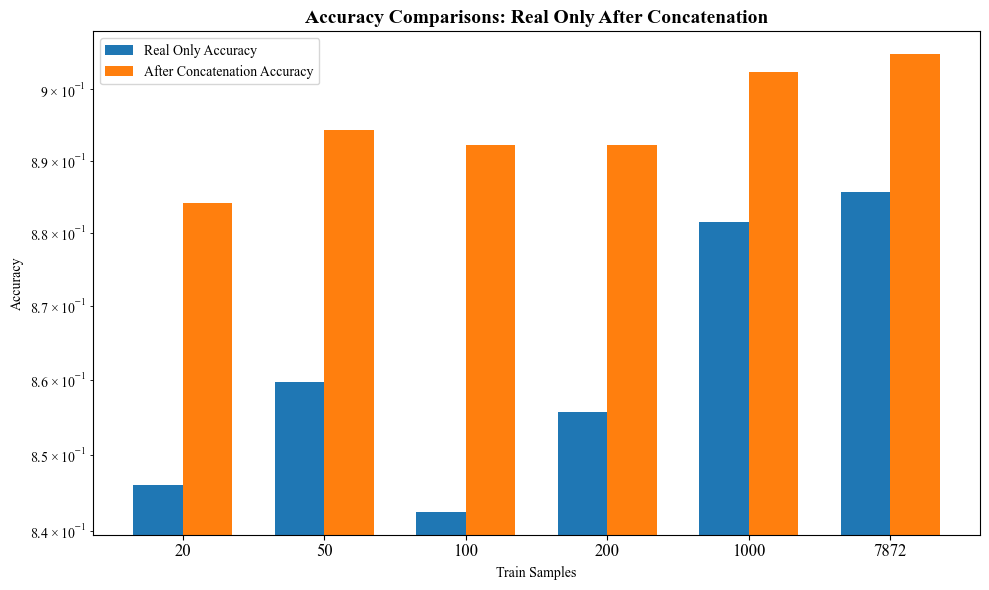

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def display_accuracy_summary(
        summary_df,
        x_label_title = "Train Samples",
        y_label = "Accuracy",
        title = "Accuracy Comparisons: Real Only After Concatenation",
        bar1_name = "Real Only Accuracy",
        bar2_name = "After Concatenation Accuracy"
    ):
    # Display the summary dataframe
    print("\nAccuracy Summary:")
    print(summary_df)
    
    # Set the font to "Times New Roman"
    plt.rcParams["font.family"] = "Times New Roman"
    
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set positions for each group of bars
    bar_width = 0.35
    index = np.arange(len(summary_df))

    # Plot bars with updated colors
    bar1 = ax.bar(index, summary_df[bar1_name], bar_width, label=bar1_name, color='#1f77b4')  # Soft blue
    bar2 = ax.bar(index + bar_width, summary_df[bar2_name], bar_width, label=bar2_name, color='#ff7f0e')  # Soft orange

    # Customize plot
    ax.set_xlabel(x_label_title)
    ax.set_ylabel(y_label)
    ax.set_yscale('log')
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(summary_df["Train Samples"])
    ax.legend()

    # Set the font for axis ticks
    ax.tick_params(axis="both", labelsize=12)

    # Display the plot
    plt.tight_layout()
    plt.show()
display_accuracy_summary(summary_df)
